In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to our processed data
PROCESSED_DATA_DIR = "../data/processed"
DATA_FILE = f"{PROCESSED_DATA_DIR}/all_features.parquet"

# Load the data
df = pd.read_parquet(DATA_FILE)

# Ensure the index is a datetime object
df.index = pd.to_datetime(df.index)

print("Data loaded successfully.")
print(f"Dataset shape: {df.shape}")
df.head()

Data loaded successfully.
Dataset shape: (95000, 34)


,Open,High,Low,Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,...,z_score_20d,volatility_20d,relative_volatility,beta_20d,vix_level,rsi_lag_1,rsi_lag_3,rsi_lag_5,target_5d_forward_return,ticker
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-16,255.210007,264.170013,254.020004,263.230011,28785800,71.234305,12.460436,4.449375,8.011061,194.302353,...,1.905422,0.523562,3.799410,0.293955,20.139999,81.690435,73.377646,59.917077,-0.053072,BA
2021-03-17,263.589996,263.609985,253.679993,254.699997,23785500,64.309790,12.502277,3.592973,8.909304,195.161093,...,1.278469,0.545873,4.021275,0.340955,20.100000,71.234305,75.480852,65.240320,-0.042992,BA
2021-03-18,256.059998,267.369995,254.729996,261.320007,24595500,66.991544,12.920675,3.209097,9.711579,196.229006,...,1.454000,0.544459,4.020911,0.330999,18.950001,64.309790,81.690435,73.377646,-0.103245,BA
2021-03-19,255.820007,258.880005,251.309998,257.750000,17330800,64.190403,12.816448,2.483896,10.332553,198.835481,...,1.149130,0.542798,3.953296,0.394621,21.430000,66.991544,71.234305,75.480852,-0.031542,BA
2021-03-22,251.229996,257.670013,250.160004,255.820007,15230000,62.664908,12.434774,1.681777,10.752997,201.784830,...,0.951430,0.546687,4.242901,0.413904,21.910000,64.190403,64.309790,81.690435,-0.017669,BA


In [2]:
# The 'ticker' column is an identifier, not a feature
features = df.drop(columns=['target_5d_forward_return', 'ticker'])
target = df['target_5d_forward_return']

# Ensure all feature columns are numeric
features = features.select_dtypes(include=np.number)

# Handle potential infinite values by replacing them with NaN
features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Then fill any NaNs that might have been created or existed before
# A simple strategy is to fill with the median of the column
for col in features.columns:
    median_val = features[col].median()
    features[col].fillna(median_val, inplace=True)


print("Features (X) and Target (y) are defined.")
print(f"Number of features: {features.shape[1]}")
print(f"Target variable name: {target.name}")

Features (X) and Target (y) are defined.
Number of features: 32
Target variable name: target_5d_forward_return


/var/folders/4z/37swpnw142j9vyyrx9kkxf800000gn/T/ipykernel_1368/3030592240.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features[col].fillna(median_val, inplace=True)
/var/folders/4z/37swpnw142j9vyyrx9kkxf800000gn/T/ipykernel_1368/3030592240.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [3]:
# Define the split point
split_date = '2023-01-01'

# Split the data based on the date
X_train = features[features.index < split_date]
X_test = features[features.index >= split_date]
y_train = target[target.index < split_date]
y_test = target[target.index >= split_date]

print("Train/Test Split Summary:")
print(f"Training data range: {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing data range:  {X_test.index.min()} to {X_test.index.max()}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples:  {len(X_test)}")

Train/Test Split Summary:
Training data range: 2021-03-16 00:00:00 to 2022-12-30 00:00:00
Testing data range:  2023-01-03 00:00:00 to 2024-12-20 00:00:00
Training samples: 45400
Testing samples:  49600


In [4]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to keep column names (optional but good practice)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

print("Features scaled successfully.")
X_train_scaled.head()

Features scaled successfully.


,Open,High,Low,Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,...,volume_momentum,bollinger_pos,z_score_20d,volatility_20d,relative_volatility,beta_20d,vix_level,rsi_lag_1,rsi_lag_3,rsi_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-16,0.284668,0.303819,0.292070,0.311928,1.271798,1.651816,1.813198,1.835125,1.259183,0.124171,...,0.756879,1.381739,1.381739,1.432953,1.870791,-0.892693,-0.513273,2.525413,1.823494,0.693177
2021-03-17,0.313236,0.301934,0.290896,0.282850,0.974980,1.070887,1.819358,1.482654,1.403122,0.127316,...,0.152745,0.900240,0.900240,1.581751,2.087914,-0.722164,-0.521091,1.648804,1.999638,1.138559
2021-03-18,0.287566,0.314587,0.294523,0.305417,1.023062,1.295871,1.880952,1.324661,1.531683,0.131227,...,0.150911,1.035048,1.035048,1.572319,2.087557,-0.758288,-0.745876,1.068274,2.519692,1.819386
2021-03-19,0.286748,0.286016,0.282708,0.293247,0.591829,1.060871,1.865609,1.026189,1.631191,0.140773,...,-0.577114,0.800908,0.800908,1.561243,2.021387,-0.527448,-0.261123,1.293104,1.643988,1.995356
2021-03-22,0.271101,0.281944,0.278735,0.286668,0.467125,0.932890,1.809420,0.696060,1.698566,0.151574,...,-0.760414,0.649075,0.649075,1.587181,2.304803,-0.457482,-0.167299,1.058265,1.064058,2.514895


In [5]:
# Initialize the model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("--- Linear Regression Performance ---")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R-squared (R²): {r2:.4f}")

# An R² close to 0 means the model performs no better than just predicting the average return.
# A negative R² means the model is worse than predicting the average.
# In finance, a small positive R² can still be significant.

--- Linear Regression Performance ---
Mean Squared Error (MSE): 0.001694
R-squared (R²): -0.0116


In [6]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest model
# n_estimators is the number of trees in the forest.
# n_jobs=-1 tells the model to use all available CPU cores to speed up training.
# random_state ensures we get the same result every time we run it.
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

print("Training Random Forest model... (This may take a minute or two)")

# Train the model on the same scaled training data
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the new model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n--- Random Forest Performance ---")
print(f"Mean Squared Error (MSE): {mse_rf:.6f}")
print(f"R-squared (R²): {r2_rf:.4f}")

Training Random Forest model... (This may take a minute or two)

--- Random Forest Performance ---
Mean Squared Error (MSE): 0.001841
R-squared (R²): -0.0999



--- Top 20 Most Important Features ---
                feature  importance
28            vix_level    0.156707
25       volatility_20d    0.064884
26  relative_volatility    0.059350
27             beta_20d    0.052586
15                  OBV    0.051132
22      volume_momentum    0.045173
12           BBB_20_2.0    0.043292
20            return_5d    0.043234
7         MACDh_12_26_9    0.035490
4                Volume    0.035478
21           return_10d    0.034205
8         MACDs_12_26_9    0.031756
14              ATRr_14    0.030535
30            rsi_lag_3    0.030368
31            rsi_lag_5    0.029510
19        STOCHd_14_3_3    0.029432
18        STOCHk_14_3_3    0.029425
29            rsi_lag_1    0.023881
6          MACD_12_26_9    0.022489
5                RSI_14    0.022479


/var/folders/4z/37swpnw142j9vyyrx9kkxf800000gn/T/ipykernel_1368/3242371765.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')


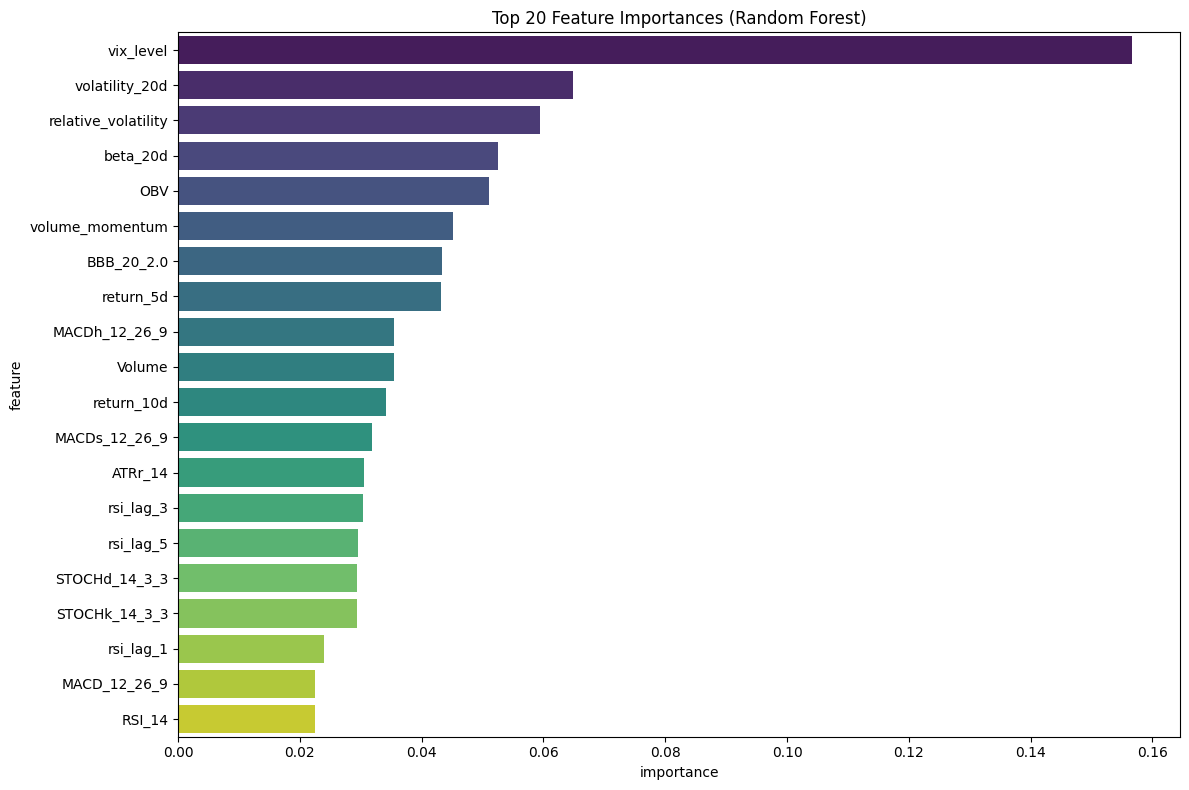

In [7]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Display the top 20 most important features
print("\n--- Top 20 Most Important Features ---")
print(feature_importance_df.head(20))

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [8]:
import xgboost as xgb

# Initialize the XGBoost Regressor model
# We'll start with some common default parameters.
# 'objective' tells the model we are doing a regression task.
# 'n_estimators' is the number of boosting rounds (trees).
xg_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

print("Training XGBoost model... (This may take a minute or two)")

# Train the model on the same scaled data
# XGBoost can handle DataFrames directly
xg_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xg = xg_model.predict(X_test_scaled)

# Evaluate the model
mse_xg = mean_squared_error(y_test, y_pred_xg)
r2_xg = r2_score(y_test, y_pred_xg)

print("\n--- XGBoost Performance ---")
print(f"Mean Squared Error (MSE): {mse_xg:.6f}")
print(f"R-squared (R²): {r2_xg:.4f}")

Training XGBoost model... (This may take a minute or two)

--- XGBoost Performance ---
Mean Squared Error (MSE): 0.002037
R-squared (R²): -0.2166


In [9]:
# Create a summary DataFrame
performance_summary = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R-squared (R²)': [r2, r2_rf, r2_xg],
    'Mean Squared Error (MSE)': [mse, mse_rf, mse_xg]
})

print("\n--- Model Performance Comparison ---")
print(performance_summary)


--- Model Performance Comparison ---
               Model  R-squared (R²)  Mean Squared Error (MSE)
0  Linear Regression       -0.011579                  0.001694
1      Random Forest       -0.099867                  0.001841
2            XGBoost       -0.216563                  0.002037
